In [1]:
### load required packages
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import time

# Low dimensional data

In [2]:
### read data
lowDim_data = pd.read_csv('../data/lowDim_dataset.csv')
lowDim_data

,Y,A,V1,V2,V3,V4,V5,V6,V7,V8,...,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22
0,19.678858,0,1.59,0.00,0.0,0.00,0.24,1.35,0.73,2.58,...,0.12,0.00,4.55,0.00,1.72,0.00,0.49,0.98,0.00,1.309683
1,17.842989,0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,1.62,...,0.27,0.00,4.87,0.00,0.81,0.27,0.27,0.00,0.00,1.719547
2,22.108788,1,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,2.12,0.00,0.00,0.00,2.12,0.996210
3,15.355899,0,0.00,0.00,0.0,0.56,0.00,0.00,0.00,0.00,...,0.00,0.00,1.12,0.00,0.00,0.00,0.00,0.00,0.00,1.504077
4,16.787813,1,1.81,0.00,0.0,0.00,0.00,0.00,0.00,1.81,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.327864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
470,23.456961,1,0.00,0.12,0.0,0.00,0.00,0.12,0.00,0.19,...,0.12,0.00,1.74,0.06,1.23,0.00,0.25,0.06,2.26,0.705076
471,18.449855,1,0.77,0.00,0.0,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,1.55,0.00,0.77,0.00,0.00,0.77,0.00,1.150572
472,18.646830,1,0.91,0.18,0.0,0.00,0.00,0.00,0.00,3.66,...,0.82,0.00,0.82,0.00,0.45,0.00,0.00,0.00,1.37,0.233490
473,25.131092,0,0.00,0.36,0.0,0.36,0.72,1.08,0.36,0.72,...,0.36,0.36,1.08,0.00,2.53,0.00,0.00,0.00,0.00,2.912351


## 1. Propensity score estimation with L2 logistic regression

In [3]:
def propensity_score(data, lam=0.01, solver='lbfgs', max_iter=100, plot=True):
    '''
    Procedure: calculate propensity scores with L2 penalized logistic regression
    
    Parameters:
    data - the dataframe we want to use
    lam - coefficient for the penalty term
    solver - solver for the logistic regression
    max_iter - maximum iteration of the logistic regression
    plot - bool,whether to print out the boxplot
    
    Returns:
    1. PS - propensity score
    2. Run time for calculating PS
    3. Boxplot to visualize how much PS overlap of the two groups
    '''
    start_time = time.time()
    T = data[['A']]
    T = np.array(T).ravel()
    V = data.iloc[:,2:]
    
    clf = LogisticRegression(random_state=0, C=lam, solver=solver, penalty='l2', max_iter=max_iter).fit(V, T)
    PS = clf.predict_proba(V)[:,1]
    
    end_time = time.time()
    run_time = end_time-start_time
    
    if plot:
        plot_df = pd.DataFrame({'Treatment':T,'PS':PS})
        plot_df.boxplot(by='Treatment')
    
    print("Run time for L2 penalized logistic regression is {:.2f} s".format(run_time))
    return PS

Run time for L2 penalized logistic regression is 0.03 s


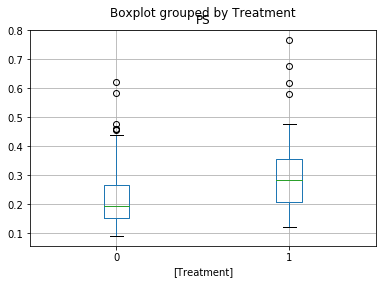

In [4]:
PS = propensity_score(lowDim_data)

## 2. ATE estimation

Note: Select criteria is t-statistics. We keep the covariate with has t-statistics absolute values larger than t_reg=2. 

With selected covariates and weights, train the below regression. The estiamted coefficient $\hat{\tau}$ is the estimated ATE.
$Y_i = \alpha_0+\tau T_i+\alpha_{11}Z_{i1}+\alpha_{12}Z_{i2}+ ... +\alpha_{1m}Z_{im}+\alpha_{21}(Z_{i1}-\bar{Z_1})T_i+\alpha_{22}(Z_{i2}-\bar{Z_2})T_i+...+\alpha_{2m}(Z_{im}-\bar{Z_m})T_i+\epsilon_i$

In [6]:
def w_reg_ATE(data, PS, t_reg=2):
    '''
    Procedure:
    1. Perform K linear regressions to select covariates to estimate ATE
    2. Calculate weights according to propensity score
    3. Estimate ATE using weighted regression
    
    Parameters:
    data - the dataframe used to estimate ATE
    PS -  propensity scores
    t_reg - the threshold for choosing covariates (choosing Z)
    '''
    start_time = time.time()
    
    ### calculate weights
    T = np.array(data[['A']]).ravel()
    weights = T/PS + (1-T)/(1-PS)
    
    
    K = data.shape[1]-2 # number of covariates in total
    Y = data[['Y']]

    t_stat_reg = np.array(())
    for i in range(1, K+1):
        idx = 'V'+str(i)
        X = data[['A',idx]]
        X = sm.add_constant(X) # adding a constant
    
        linear_reg = sm.OLS(Y, X).fit() 
        cov = linear_reg.cov_params()
        std_err = np.sqrt(np.diag(cov))
        t_stat_reg = np.append(t_stat_reg,np.array(round(linear_reg.params[2] / std_err[2],2)))
    
    
    # construct required independent variables
    T = data['A']
    Z = data.iloc[:,2:].iloc[:,abs(t_stat_reg)>t_reg]
    centralized_Z = data.iloc[:,2:].iloc[:,abs(t_stat_reg)>t_reg] - \
                data.iloc[:,2:].iloc[:,abs(t_stat_reg)>t_reg].mean(axis=0)
    centralized_Z_T = centralized_Z.multiply(T, axis='index')
    
    # X and Y for training weighted regression
    X_train = pd.concat([T,Z,centralized_Z,centralized_Z_T],axis=1)
    Y_train = np.array(Y).ravel()
    
    reg = LinearRegression(fit_intercept=True).fit(X_train, Y_train, sample_weight=weights)
    ATE = reg.coef_[0]
    
    end_time = time.time()
    
    print("Estimated ATE is {:.2f}".format(ATE))
    print("Run time for ATE estimation is {:.2f} s".format(end_time-start_time))

In [7]:
w_reg_ATE(lowDim_data, PS)

Estimated ATE is 2.49
Run time for ATE estimation is 0.14 s


# High dimensional data

In [8]:
### read data
highDim_data = pd.read_csv('../data/highDim_dataset.csv')
highDim_data

,Y,A,V1,V2,V3,V4,V5,V6,V7,V8,...,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185
0,-11.682472,1,0,1,2,16,3,-1,13,-0.13,...,5,7,8,6,8,-1,-1,-1,-1,-1
1,-13.176546,0,1,1,12,14,14,14,13,0.24,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,-2.195401,1,0,1,21,22,10,10,14,0.27,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,-0.005454,1,1,1,9,20,11,2,10,0.09,...,-10,-10,-10,-10,-10,-10,-10,-10,-10,-10
4,-1.987538,1,1,1,7,16,16,11,6,0.15,...,70,70,80,70,80,-10,-10,-10,-10,-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-15.054763,0,0,1,14,18,19,19,10,0.36,...,7,8,9,10,9,6,8,8,10,8
1996,-8.310797,0,0,1,21,22,15,15,12,0.02,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1997,-15.645703,0,1,1,14,20,5,5,3,0.56,...,6,6,8,7,5,6,5,7,7,6
1998,-18.302366,1,0,1,2,16,7,-1,11,0.50,...,7,8,8,7,6,-1,-1,-1,-1,-1


Run time for L2 penalized logistic regression is 0.79 s


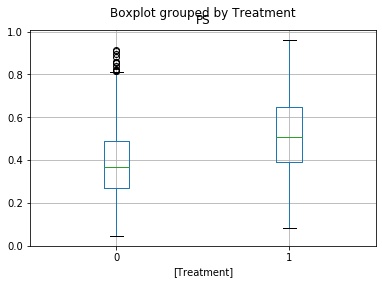

In [9]:
PS = propensity_score(highDim_data, lam=1, solver='liblinear', max_iter=1000)

In [10]:
w_reg_ATE(highDim_data, PS)

Estimated ATE is -2.96
Run time for ATE estimation is 0.79 s
